In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ukbb_recessive.regression.plotting as plotting

In [2]:
# plps file
plps = pd.read_csv(
    ".../450k/plp_selection/basic/new_gene_names/"
    "new_freq/new_relatedness/all_chr_total_presumable_plps_HFE_final_sorted.txt", sep="\t")

#gene panel
gene_panel = pd.read_csv(".../450k/regions/gene-panel-gencode-v34.txt", header=None)
gene_panel.columns = ['gene', 'panel']

# samples of interest: European & non-related without hom and comp_het
# european_non_rel_samples = (
#     ".../450k/samples/european_non_related_no_withdrawal_to_include_450k.no_hom_comp_het.txt"
# )
european_non_rel_samples = (
    ".../450k/samples/european_non_related_no_withdrawal_to_include_450k.txt"
)

with open(european_non_rel_samples, 'r') as f:
    european_non_rel_samples = [l.strip() for l in f.readlines()]

N = len(european_non_rel_samples)
print (f"Number of samples: {N}")

# mild plps; were taken from Hila's excel file; they are the mild variants
mild_plps = pd.read_csv('mild_variants.csv', sep='\t').rename(columns={'hets': 'mild_hets', 'homs': 'mild_homs'}).drop('panel', axis=1)


Number of samples: 378751


In [3]:
# separate mild variants
plps = plps.merge(mild_plps, how='left')
plps[['mild_hets', 'mild_homs']] = plps[['mild_hets', 'mild_homs']].fillna(0)
plps['hets'] = plps['hets'] - plps['mild_hets']
plps['homs'] = plps['homs'] - plps['mild_homs']

# add gene panel information
plps = plps.merge(gene_panel, how='inner', on='gene')
plps = plps[~plps['panel'].isin(['Tumor', 'No_panel', 'Cardiovascular'])]

In [9]:
def add_data_per_gene(plps):
    # per gene genotypes count
    plps_gene = plps.groupby(['panel', 'gene'])[['hets', 'homs', 'mild_hets', 'mild_homs']].sum().reset_index()

    # allele cound
    plps_gene['AC'] = plps_gene['hets'] + 2*plps_gene['homs']
    plps_gene['mild_AC'] = plps_gene['mild_hets'] + 2*plps_gene['mild_homs']

    # allele frequency
    plps_gene['AF'] = plps_gene['AC'] / (2*N)
    plps_gene['mild_AF'] = plps_gene['mild_AC'] / (2*N)
    plps_gene['total_AF'] = plps_gene['AF'] + plps_gene['mild_AF']

    # heterozygotes probability
    plps_gene['hets_expected'] = 2*plps_gene['AF']*(1-plps_gene['AF'])
    plps_gene['mild_hets_expected'] = 2*plps_gene['mild_AF']*(1-plps_gene['mild_AF'])

    # at-risk-couples
    plps_gene['at_risk_couples'] = (plps_gene['hets_expected']**2 + 2*plps_gene['hets_expected']*plps_gene['mild_hets_expected']) 
    plps_gene['at_risk_couples_first_cousins'] = plps_gene['hets_expected']*0.125

    plps_gene['CR'] = plps_gene['at_risk_couples_first_cousins'] / plps_gene['at_risk_couples'] 

    return plps_gene

def add_data_per_panel(plps_gene):
    # calculate CR on a panel level
    plps_panel = plps_gene.groupby('panel').agg({'at_risk_couples': 'sum', 'at_risk_couples_first_cousins': 'sum', 'total_AF': 'std'}).reset_index()

    plps_panel['affected_offsprings']  = plps_panel['at_risk_couples'] * 100000 / 4
    plps_panel['affected_offsprings_first_cousins']  = plps_panel['at_risk_couples_first_cousins'] * 100000 / 4

    plps_panel['CR'] = plps_panel['at_risk_couples_first_cousins'] / plps_panel['at_risk_couples']

    return plps_panel

plps_gene = add_data_per_gene(plps)
plps_panel = add_data_per_panel(plps_gene)
plps_panel = plps_panel.sort_values('CR', ascending=False).reset_index(drop=True)

plps_panel.to_csv('../../../../data/tables/CR.csv', sep='\t', index=False)

In [10]:
results = []

for threshold in range(1, 5350, 10):
    plps_rare = plps[(plps['hets'] <= threshold)].copy()
    plps_gene = add_data_per_gene(plps_rare)
    plps_panel = add_data_per_panel(plps_gene)

    plps_panel = plps_panel.sort_values('CR', ascending=False).reset_index(drop=True)
    plps_panel['rank'] = plps_panel.index + 1
    plps_panel['threshold'] = threshold
    results.append(plps_panel)

results = pd.concat(results)


<Axes: xlabel='threshold', ylabel='rank'>

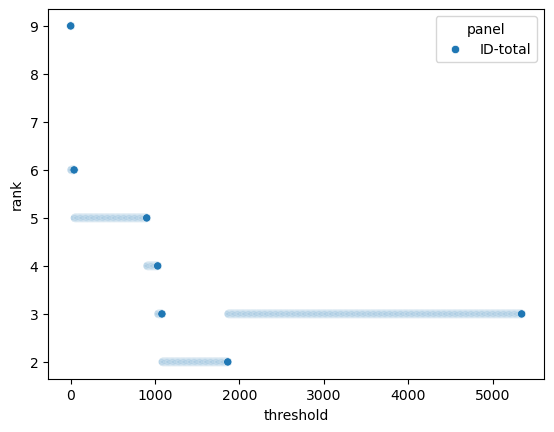

In [19]:
# sns.scatterplot(data=results[results['panel'].isin(['ID-total', 'Neuromuscular'])], x='threshold', y='rank', hue='panel')

sns.scatterplot(data=results[results['panel'].isin(['ID-total'])], x='threshold', y='rank', hue='panel')

<Axes: xlabel='threshold', ylabel='rank'>

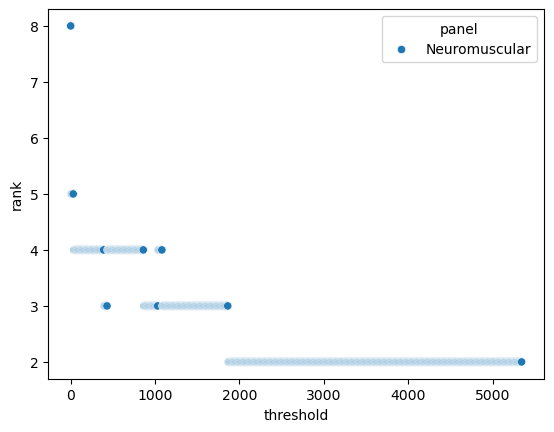

In [28]:
sns.scatterplot(data=results[results['panel'].isin([ 'Neuromuscular'])], x='threshold', y='rank', hue='panel')


In [27]:
results[results['threshold'] == 1051]

panel  at_risk_couples  at_risk_couples_first_cousins  \
0             Hematologic         0.000019                       0.002375   
1   Skeletal+Craniofacial         0.000026                       0.002886   
2                ID-total         0.000341                       0.027612   
3           Neuromuscular         0.000098                       0.007589   
4                Overlaps         0.000372                       0.025026   
5           Immune_system         0.000085                       0.005022   
6                Deafness         0.000089                       0.004697   
7            Cilia+Kidney         0.000163                       0.007655   
8                    Derm         0.000088                       0.003911   
9            Metabolic-ID         0.000843                       0.035535   
10              Metabolic         0.000729                       0.030041   
11              Blindness         0.000224                       0.008949   
12              Endocrine         0.000087                       0.002442   

    total_AF  affected_offsprings  affected_offsprings_first_cousins  \
0   0.000256             0.479036                          59.375805   
1   0.000268             0.644274                          72.137673   
2   0.000459             8.534454                         690.295910   
3   0.000385             2.440640                         189.731050   
4   0.000635             9.296483                         625.647240   
5   0.000517             2.133536                         125.551216   
6   0.000599             2.213055                         117.418706   
7   0.000626             4.071056                         191.377548   
8   0.000732             2.202553                          97.782787   
9   0.000677            21.064351                         888.373872   
10  0.004600            18.217870                         751.027555   
11  0.000713             5.610742                         223.714017   
12  0.001061             2.169742                          61.041071   

            CR  rank  threshold  
0   123.948421     1       1051  
1   111.967387     2       1051  
2    80.883431     3       1051  
3    77.738222     4       1051  
4    67.299351     5       1051  
5    58.846542     6       1051  
6    53.057301     7       1051  
7    47.009314     8       1051  
8    44.395208     9       1051  
9    42.174281    10       1051  
10   41.224773    11       1051  
11   39.872451    12       1051  
12   28.132865    13       1051